# Spotify Songs Clustering

## Table of contents 

// TODO user table of contents extension on jupyter notebook

In [12]:
# Libraries 
import numpy as np
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns
import datetime as dt
import warnings
import networkx as nx
import re
import time
from tqdm import tqdm

from sklearn.feature_extraction.text import TfidfVectorizer


from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
import nltk

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE


from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
import random 
from yellowbrick.cluster import KElbowVisualizer

warnings.filterwarnings("ignore")

# Exploratory Data Analysis (EDA) 
- Data Import / Cleaning and Vectorization
- Distribution of datapoints 

In [45]:
# Spotify tracks dataset (for recommendation system)
df = pd.read_csv("Data/spotify_songs.csv", index_col=0)
df = df.dropna()
#Filter English songs
df = df[df['language'] == 'en']
# Lyrics example
print(df['lyrics'][0])
#Snapshot of dataset
df.head(2)

The trees, are singing in the wind The sky blue, only as it can be And the angels, smiled at me I saw you, in that lonely bench At half past four, I kissed your soft soft hands and at 6 I kissed your lips and the angels smiled, I thought Hey I feel alive! The park sign, said it was closed And we jumped that fence with no cares at all and we kissed under a tree We danced, under the midnight sun And I loved you, without knowing you at all and we laughed and felt so free and the angels they smiled, I thought Hey, I feel alive!


,track_name,track_artist,lyrics,track_popularity,track_album_id,track_album_name,track_album_release_date,playlist_name,playlist_id,playlist_genre,...,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_ms,language
track_id,,,,,,,,,,,,,,,,,,,,,
004s3t0ONYlzxII9PLgU6z,I Feel Alive,Steady Rollin,"The trees, are singing in the wind The sky blu...",28,3z04Lb9Dsilqw68SHt6jLB,Love & Loss,2017-11-21,Hard Rock Workout,3YouF0u7waJnolytf9JCXf,rock,...,-4.739,1,0.0442,0.01170,0.00994,0.347,0.404,135.225,373512,en
00chLpzhgVjxs1zKC9UScL,Poison,Bell Biv DeVoe,"NA Yeah, Spyderman and Freeze in full effect U...",0,6oZ6brjB8x3GoeSYdwJdPc,Gold,2005-01-01,"Back in the day - R&B, New Jack Swing, Swingbe...",3a9y4eeCJRmG9p4YKfqYIx,r&b,...,-7.504,0,0.2160,0.00432,0.00723,0.489,0.650,111.904,262467,en


In [46]:
# Data Analysis
print(df.shape)
# Unique values of genres
print(df['playlist_genre'].unique())
# Statistics from numerical columns
df.describe()
# Standarization of the numerical columns 
num_cols = ['track_popularity','danceability','duration_ms','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness','valence','tempo']
scaler = StandardScaler()
df[num_cols] = scaler.fit_transform(df[num_cols])

(15405, 24)
['rock' 'r&b' 'pop' 'edm' 'rap' 'latin']


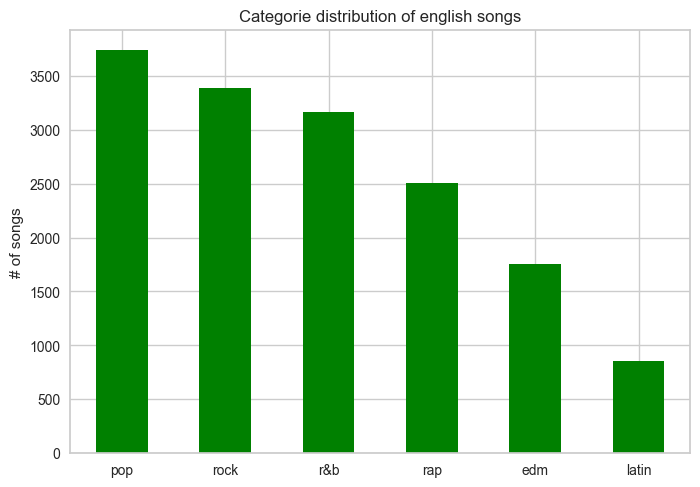

In [47]:
#Plot categories distribution
df['playlist_genre'].value_counts().plot.bar(rot=0, color='green')
plt.title('Categorie distribution of english songs')
plt.ylabel('# of songs')
None

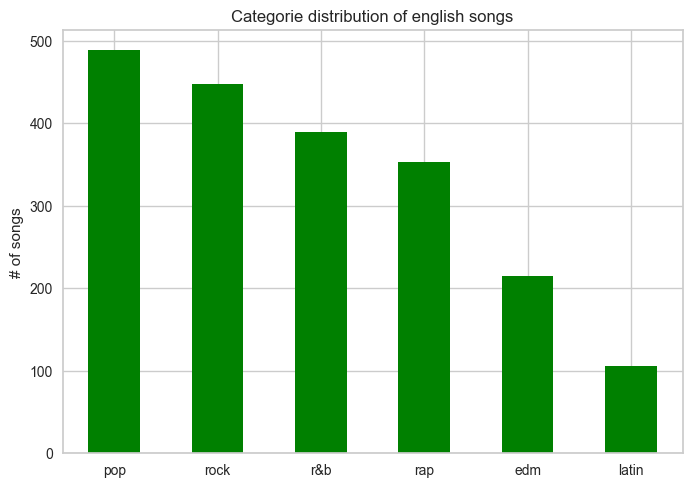

In [49]:
########### IM USING A SUBSET OF THIS DATA FOR TESTING ALL METHODS. I WILL CONNECT TO HPC TO DO THE FULL DATA BATCH
df = df[:2000]

#Plot categories distribution
df['playlist_genre'].value_counts().plot.bar(rot=0, color='green')
plt.title('Categorie distribution of english songs')
plt.ylabel('# of songs')
None

In [50]:
# Text Cleaning of song lyrics

def preprocess_text(text, remove_stopwords):
    """This utility function sanitizes a string by:
        - removing links
        - removing special characters
        - removing numbers
        - removing stopwords
        - transforming in lowercase
        - removing excessive whitespaces
        Args:
            text (str): the input text you want to clean
            remove_stopwords (bool): whether or not to remove stopwords
        Returns:
            str: the cleaned text
        """
    # remove links
    text = re.sub(r"http\S+", "", text)
    # remove special chars and numbers
    text = re.sub("[^A-Za-z]+", " ", text)
    # remove stopwords
    if remove_stopwords:
        # 1. tokenize
        tokens = word_tokenize(text)
        # 2. check if stopword
        tokens = [
            w for w in tokens if not w.lower() in stopwords.words("english")
        ]
        # 3. join back together
        text = " ".join(tokens)
    # return text in lower case and stripped of whitespaces
    text = text.lower().strip()
    return text


#Apply this function to the song lyrics ()

t1 = time.time()
print('Starting cleaning of data')
tqdm.pandas(dynamic_ncols=True, smoothing=0.01)
#Use function preprocess_text() for every row, assign results to new column 
df['cleaned'] = df['lyrics'].progress_apply(lambda x: preprocess_text(x, remove_stopwords=True))
print('Finished cleaning of data')
t2 = time.time()
print(f'Elapsed time for initilization: {t2-t1:.2f}s')

Starting cleaning of data


100%|██████████| 2000/2000 [02:14<00:00, 14.89it/s]

Finished cleaning of data
Elapsed time for initilization: 134.32s


In [51]:
# Text vectorization using sklearn tfidf vectorizer to the preprocessed cleaned data
vectorizer = TfidfVectorizer(sublinear_tf=True, min_df=5, max_df=0.95)
# fit_transform applies TF-IDF to clean texts - we save the array of vectors in X
X_text = vectorizer.fit_transform(df['cleaned'])
X_text = X_text.toarray()
X_text.shape

(2000, 4045)

In [52]:
X_numerical = df[['danceability','duration_ms','energy','key','loudness','mode','speechiness','acousticness','instrumentalness','liveness',	'valence','tempo']].values
X_numerical.shape
# Assuming X_text is your vectorized text data and X_numerical is your standardized numerical data
combined_data = np.hstack((X_text, X_numerical))

In [53]:
combined_data.shape

(2000, 4057)

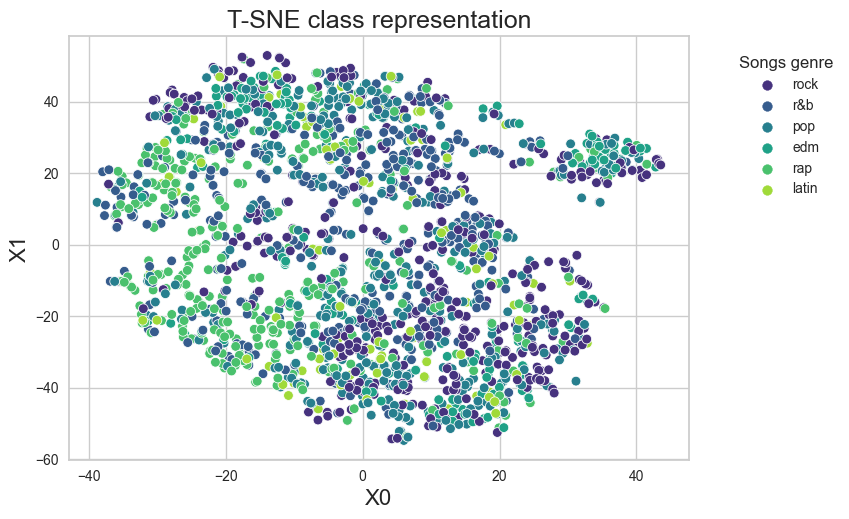

In [66]:
# Redice the dimensionality of data points to plot the datapoint distribution
pca = PCA(n_components=10, random_state=42)
# pass our X to the pca and store the reduced vectors into pca_vecs
pca_vecs = pca.fit_transform(X_numerical)

X_embedded = TSNE(n_components=2, learning_rate="auto",
                  init="random").fit_transform(X_numerical)
                  

plt.title("T-SNE class representation", fontdict={"fontsize": 18})
# set axes names
plt.xlabel("X0", fontdict={"fontsize": 16})
plt.ylabel("X1", fontdict={"fontsize": 16})
# create scatter plot with seaborn, where hue is the class used to group the data
sns.scatterplot(data=df,
                x=X_embedded[:, 0],
                y=X_embedded[:, 1],
                hue='playlist_genre',
                palette="viridis")
#plt.legend(loc='upper right')
plt.legend(bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=1,
           title='Songs genre')
plt.show()

In [ ]:
If your data points from different genres are not clearly grouped together in a PCA (Principal Component Analysis) plot, it suggests tmhat the variance in your data may not be primarily driven by the genre variable. In such cases, it's important to consider the following:

# Clustering

### K-Means

### K-NN

## Clasification
- Neural Network
- Transformer (BERT)

### Neural Network

### BERT 